In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import yaml
import shutil
import textwrap
from datetime import datetime

sns.set_theme()

In [2]:
### All global variables that would be passed as arguments in a python script
# Do not think that I need them, after I have moved the load_cache and load_worker to the PostProcessing
#pipeline_txt_name = "pipelines.txt"
#cache_hits_misses_name = "cache_hits_and_misses.txt"

output_folder = "/home/nils/Downloads/output_plots"
input_folder = "/home/nils/Downloads/"
time_stamp = "1740083964"
worker_statistics_csv_name = f"worker_statistics_{time_stamp}.csv"
smaller_worker_statistics_csv_name = f"worker_statistics_{time_stamp}_small.csv"
cache_statistics_csv_name = f"cache_statistics_{time_stamp}.csv"
worker_statistics_csv_path = os.path.join(input_folder, worker_statistics_csv_name)
cache_statistics_csv_path = os.path.join(input_folder, cache_statistics_csv_name)


# Remove the output_folder and then create it again
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)

In [3]:
# Converts a large number to a string 
def format_si_units(number):
    # Define SI unit prefixes
    si_prefixes = ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y']

    # Handle zero as a special case
    if number == 0:
        return "0"

    # Determine the sign of the number
    sign = ''
    if number < 0:
        sign = '-'
        number = -number

    # Determine the order of magnitude
    order_of_magnitude = 0
    while number >= 1000 and order_of_magnitude < len(si_prefixes) - 1:
        number /= 1000.0
        order_of_magnitude += 1

    # Format the number to one decimal place and append the SI prefix
    formatted_number = f"{number:.3f}{si_prefixes[order_of_magnitude]}"

    # Add the sign back to the formatted number
    return sign + formatted_number


# Converting pipelines.txt to a dict of pipeline id to a title
def extract_pipeline_data(input_path):
    with open(input_path, 'r') as input_file:
        input_text = input_file.read()

    pipeline_dict = {}
    # Split the input text by the delimiter
    pipeline_sections = input_text.split("############################################")
    physical_pattern = re.compile(r"\bPhysical\w+")

    for section in pipeline_sections:
        # Find the pipeline ID in the section
        pipeline_match = re.search(r"Pipeline:\s*(\d+)", section)
        if pipeline_match:
            pipeline_id = int(pipeline_match.group(1))
            if pipeline_id not in pipeline_dict:
                pipeline_dict[pipeline_id] = []
            
            # Find all words starting with 'Physical' in the section
            physical_matches = physical_pattern.findall(section)
            cleaned_matches = [match.replace("Physical", "").replace("Operator", "").replace("Stream", "") for match in physical_matches]
            pipeline_dict[pipeline_id].extend(cleaned_matches)
    
    # Concatenate multiple values with "_"
    return {key: "_".join(values) for key, values in pipeline_dict.items()}

In [4]:
# Gathering all cache statistic files across all folders
def load_cache_statistics():
    return pd.read_csv(cache_statistics_csv_path)

# Converting query engine statistics to statistics csv
def load_worker_statistics():
    needed_columns = ["query", "slice_cache", "number_of_worker_threads", "degree_of_disorder", "throughput", "duration"]
    df = pd.read_csv(worker_statistics_csv_path, usecols=needed_columns)
    return df

In [5]:
# Reading the combined data into dataframe named df and printing a little summary of the data frame
df = load_worker_statistics()
    
# General info
print("### DataFrame Summary ###\n")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
print("Columns and Data Types:")
print(df.dtypes, "\n")

# Number of unique values per column
print("Number of Unique Values per Column:")
print(df.nunique(), "\n")

# Check for missing values
print("Missing Values:")
print(df.isnull().sum(), "\n")

# Descriptive statistics for numeric columns
print("Descriptive Statistics (Numeric Columns):")
print(df.describe().T, "\n")

# Display a sample of rows
print("Sample Rows:")
display(df.head(5))

### DataFrame Summary ###

Shape: 34778724 rows, 6 columns

Columns and Data Types:
degree_of_disorder           object
number_of_worker_threads      int64
query                        object
duration                    float64
throughput                  float64
slice_cache                  object
dtype: object 

Number of Unique Values per Column:
degree_of_disorder               6
number_of_worker_threads         3
query                            4
duration                     43659
throughput                  112990
slice_cache                     13
dtype: int64 

Missing Values:
degree_of_disorder          0
number_of_worker_threads    0
query                       0
duration                    0
throughput                  0
slice_cache                 0
dtype: int64 

Descriptive Statistics (Numeric Columns):
                               count          mean           std        min  \
number_of_worker_threads  34778724.0  7.071059e+00  6.481917e+00   1.000000   
duration    

,degree_of_disorder,number_of_worker_threads,query,duration,throughput,slice_cache
0,0_NONE,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,0.000009,2.844444e+07,LRU_1
1,0_NONE,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,0.000005,5.120000e+07,LRU_1
2,0_NONE,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,0.000002,2.700000e+07,LRU_1
3,0_NONE,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,0.000005,5.120000e+07,LRU_1
4,0_NONE,1,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,0.000005,5.120000e+07,LRU_1


In [6]:
%%script true
# Plotting the total no. tuples, no. tasks, total duration per no. worker threads
df = load_worker_statistics()
# Aggregate the data by number_of_worker_threads
aggregated_data = df.groupby(["number_of_worker_threads", "buffer_size_in_bytes"]).agg(
    total_tuples=('num_tuples', 'sum'),
    total_tasks=('task_id', 'count'),
    total_duration=('duration', 'sum')
).reset_index()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot total number of tuples
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_tuples",
    palette="pastel",
    hue="buffer_size_in_bytes",
    ax=axes[0]
)
axes[0].set_title("Total Number of Tuples per Worker Threads")
axes[0].set_xlabel("Number of Worker Threads")
axes[0].set_ylabel("Total Tuples")

# Plot total number of tasks
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_tasks",
    palette="pastel",
    hue="buffer_size_in_bytes",
    ax=axes[1]
)
axes[1].set_title("Total Number of Tasks per Worker Threads")
axes[1].set_xlabel("Number of Worker Threads")
axes[1].set_ylabel("Total Tasks")

# Plot total duration
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_duration",
    palette="pastel",
    hue="buffer_size_in_bytes",
    ax=axes[2]
)
axes[2].set_title("Total Duration per Worker Threads")
axes[2].set_xlabel("Number of Worker Threads")
axes[2].set_ylabel("Total Duration (ms)")

# Adjust layout
plt.tight_layout()
plt.show()
plt.close(fig)


In [7]:
%%script true

# Plotting the throughput and duration for each pipeline in intervals
# Only do this for buffer_size_in_bytes == 8196
df = load_worker_statistics()
df = df[df['buffer_size_in_bytes'] == 8196]

# Normalize the timestamps to timedelta and milliseconds
df['start_time_normalized'] = pd.to_timedelta(df['start_time_normalized'])
df['start_time_normalized_ms'] = df['start_time_normalized'].dt.total_seconds() * 1000
df['end_time_normalized'] = pd.to_timedelta(df['end_time_normalized'])

# Create intervals
interval_size_in_ms = 500
intervals = pd.cut(df['start_time_normalized_ms'], bins=range(0, int(df['start_time_normalized_ms'].max()) + interval_size_in_ms, interval_size_in_ms), right=False)
df['interval'] = intervals
df['interval'] = df['interval'].apply(lambda x: x.left)

# Group by pipeline_id and create a plot for each group
interesting_pipeline_ids = df["pipeline_id"].unique()
df = df[df['pipeline_id'].isin(interesting_pipeline_ids)]
for pipeline_id, group in df.groupby("pipeline_id"):
    # Select only the necessary columns for computation
    group = group[['interval', 'number_of_worker_threads', 'throughput', 'duration', 'num_tuples']]
    
    sum_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=True).agg({
        'num_tuples': 'sum',
        'duration': 'sum',
    })
    # Calculate throughput as sum(num_tuples) / sum(duration)
    sum_group['throughput'] = sum_group['num_tuples'] / sum_group['duration']

    # Calculate the average duration
    avg_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=False)['duration'].mean()

    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    # Plot throughput vs interval
    sns.boxplot(
        data=sum_group,
        x="interval",
        y="throughput",
    palette="pastel",
        hue="number_of_worker_threads",
        ax=axes[0]
    )
    axes[0].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Interval ({interval_size_in_ms}ms)")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Throughput [tup/s]")

    # Plot duration vs interval
    sns.boxplot(
        data=avg_group,
        x="interval",
        y="duration",
    palette="pastel",
        hue="number_of_worker_threads",
        ax=axes[1]
    )
    axes[1].set_title(f"Pipeline ID {pipeline_id}: Duration vs Interval ({interval_size_in_ms}ms)")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Duration (ms)")

    # Plot no. tuples vs interval
    sns.boxplot(
        data=sum_group,
        x="interval",
        y="num_tuples",
    palette="pastel",
        hue="number_of_worker_threads",
        ax=axes[2]
    )
    axes[2].set_title(f"Pipeline ID {pipeline_id}: No. Tuples vs Interval ({interval_size_in_ms}ms)")
    axes[2].set_xlabel("Interval")
    axes[2].set_ylabel("Num Tuples")

    # Adjust layout and save the figure
    plt.tight_layout()
    figure_path = os.path.join(output_folder, f"pipeline_{pipeline_id}_intervals_{interval_size_in_ms}ms.png")
    plt.savefig(figure_path)
    plt.show()
    plt.close(fig)  # Close the figure to free memory



In [8]:
%%script true
#Plotting duration and throughput as a lineplot over the start_time_normalized
# Unique pipeline IDs
df = load_worker_statistics()
unique_pipeline_ids = df['pipeline_id'].unique()

# Generate one plot per pipeline
for pipeline_id in unique_pipeline_ids:
    # Filter data for the current pipeline_id
    pipeline_data = df[df['pipeline_id'] == pipeline_id]
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot throughput
    sns.lineplot(
        data=pipeline_data,
        x='start_time_normalized',
        y='throughput',
    palette="pastel",
        hue='buffer_size_in_bytes',
        marker="o",
        ax=axes[0]
    )
    axes[0].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Time")
    axes[0].set_xlabel("Start Time")
    axes[0].set_ylabel("Throughput")
    
    # Plot duration
    sns.lineplot(
        data=pipeline_data,
        x='start_time_normalized',
        y='duration',
    palette="pastel",
        hue='buffer_size_in_bytes',
        marker="o",
        ax=axes[1]
    )
    axes[1].set_title(f"Pipeline ID {pipeline_id}: Duration vs Time")
    axes[1].set_xlabel("Start Time")
    axes[1].set_ylabel("Duration")
    
    # Adjust layout for readability
    plt.tight_layout()
    
    # Save the figure
    figure_path = os.path.join(output_folder, f"pipeline_{pipeline_id}.png")
    #plt.savefig(figure_path)
    plt.show()
    plt.close(fig)  # Close the figure to save memory

In [9]:
worker_stats_df = load_worker_statistics()
worker_stats_df['query'].unique()

array(['SELECT MIN(value) FROM tcp_source WINDOW SLIDING (timestamp, size 10000 ms, advance by 10000 ms) INTO csv_sink',
       'SELECT MIN(value) FROM tcp_source WINDOW SLIDING (timestamp, size 10000 ms, advance by 100 ms) INTO csv_sink',
       'SELECT MIN(value) FROM tcp_source WINDOW SLIDING (timestamp, size 1000000 ms, advance by 10000 ms) INTO csv_sink',
       'SELECT MIN(value) FROM tcp_source WINDOW SLIDING (timestamp, size 1000000 ms, advance by 100 ms) INTO csv_sink'],
      dtype=object)

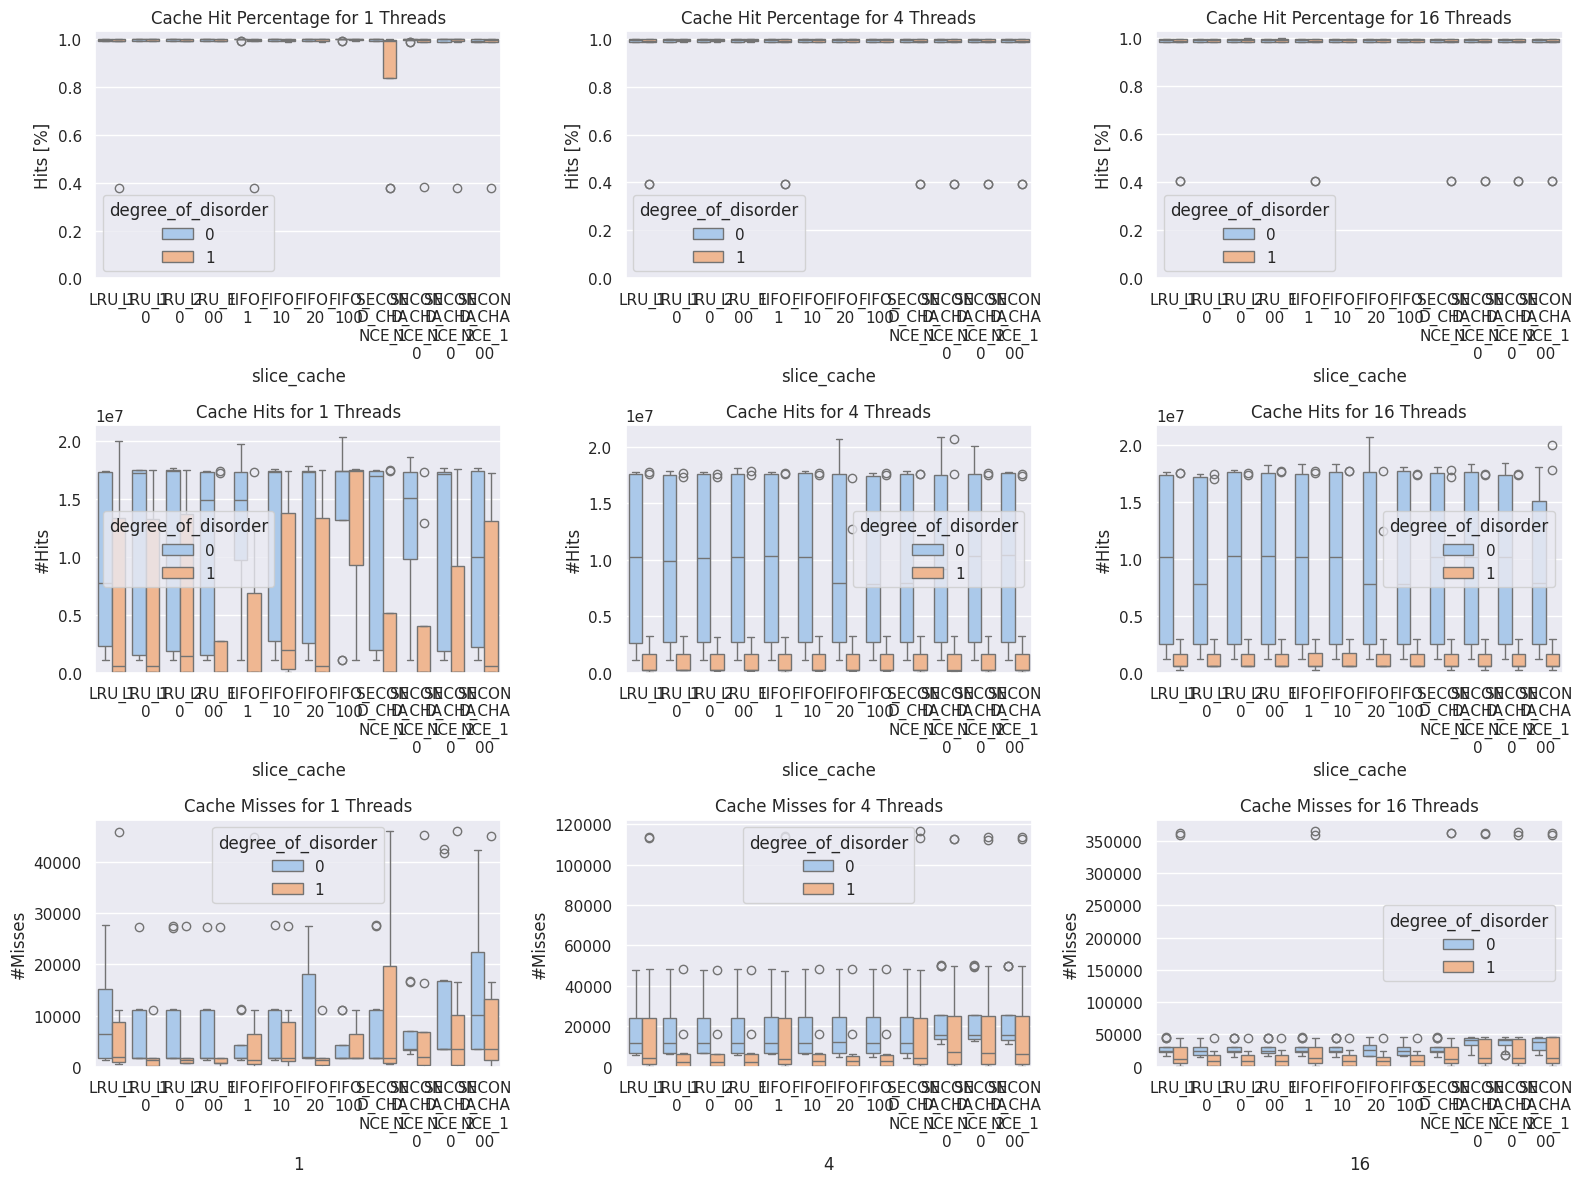

In [10]:
# Plotting the number of hits and misses per cache type
cache_stats_combined_df = load_cache_statistics()
interesting_param = "number_of_worker_threads"
x_param="slice_cache"
hue = "degree_of_disorder"
y_params = ["hit_percentage", "hits_total", "misses_total"]
cache_stats_combined_df["hit_percentage"] = cache_stats_combined_df["hits_total"] / (cache_stats_combined_df["hits_total"] + 
                                                                                     cache_stats_combined_df["misses_total"])

cache_stats_combined_df[x_param] = cache_stats_combined_df[x_param].apply(lambda x: '\n'.join(textwrap.wrap(x, width=5)))

# Create a subplot grid.
unique_params = cache_stats_combined_df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(3, n_params, figsize=(16, 12), squeeze=False)
for idx, param in enumerate(unique_params):
    subset = cache_stats_combined_df[cache_stats_combined_df[interesting_param] == param]

    ax = axes[0][idx]
    sns.boxplot(x=x_param, y=y_params[0], hue=hue, data=subset, ax=ax, palette="pastel")
    ax.set_title(f"Cache Hit Percentage for {param} Threads")
    ax.set_xlabel(x_param)
    ax.set_ylabel(f"Hits [%]")
    ax.set_ylim(bottom=0)

    ax = axes[1][idx]
    sns.boxplot(x=x_param, y=y_params[1], hue=hue, data=subset, ax=ax, palette="pastel",)
    ax.set_title(f"Cache Hits for {param} Threads")
    ax.set_xlabel(x_param)
    ax.set_ylabel(f"#Hits")
    ax.set_ylim(bottom=0)

    ax = axes[2][idx]
    sns.boxplot(x=x_param, y=y_params[2], hue=hue, data=subset, ax=ax, palette="pastel")
    ax.set_title(f"Cache Misses for {param} Threads")
    ax.set_xlabel(param)
    ax.set_ylabel(f"#Misses")
    #ax.set_yscale('log')
    ax.set_ylim(bottom=0)


plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

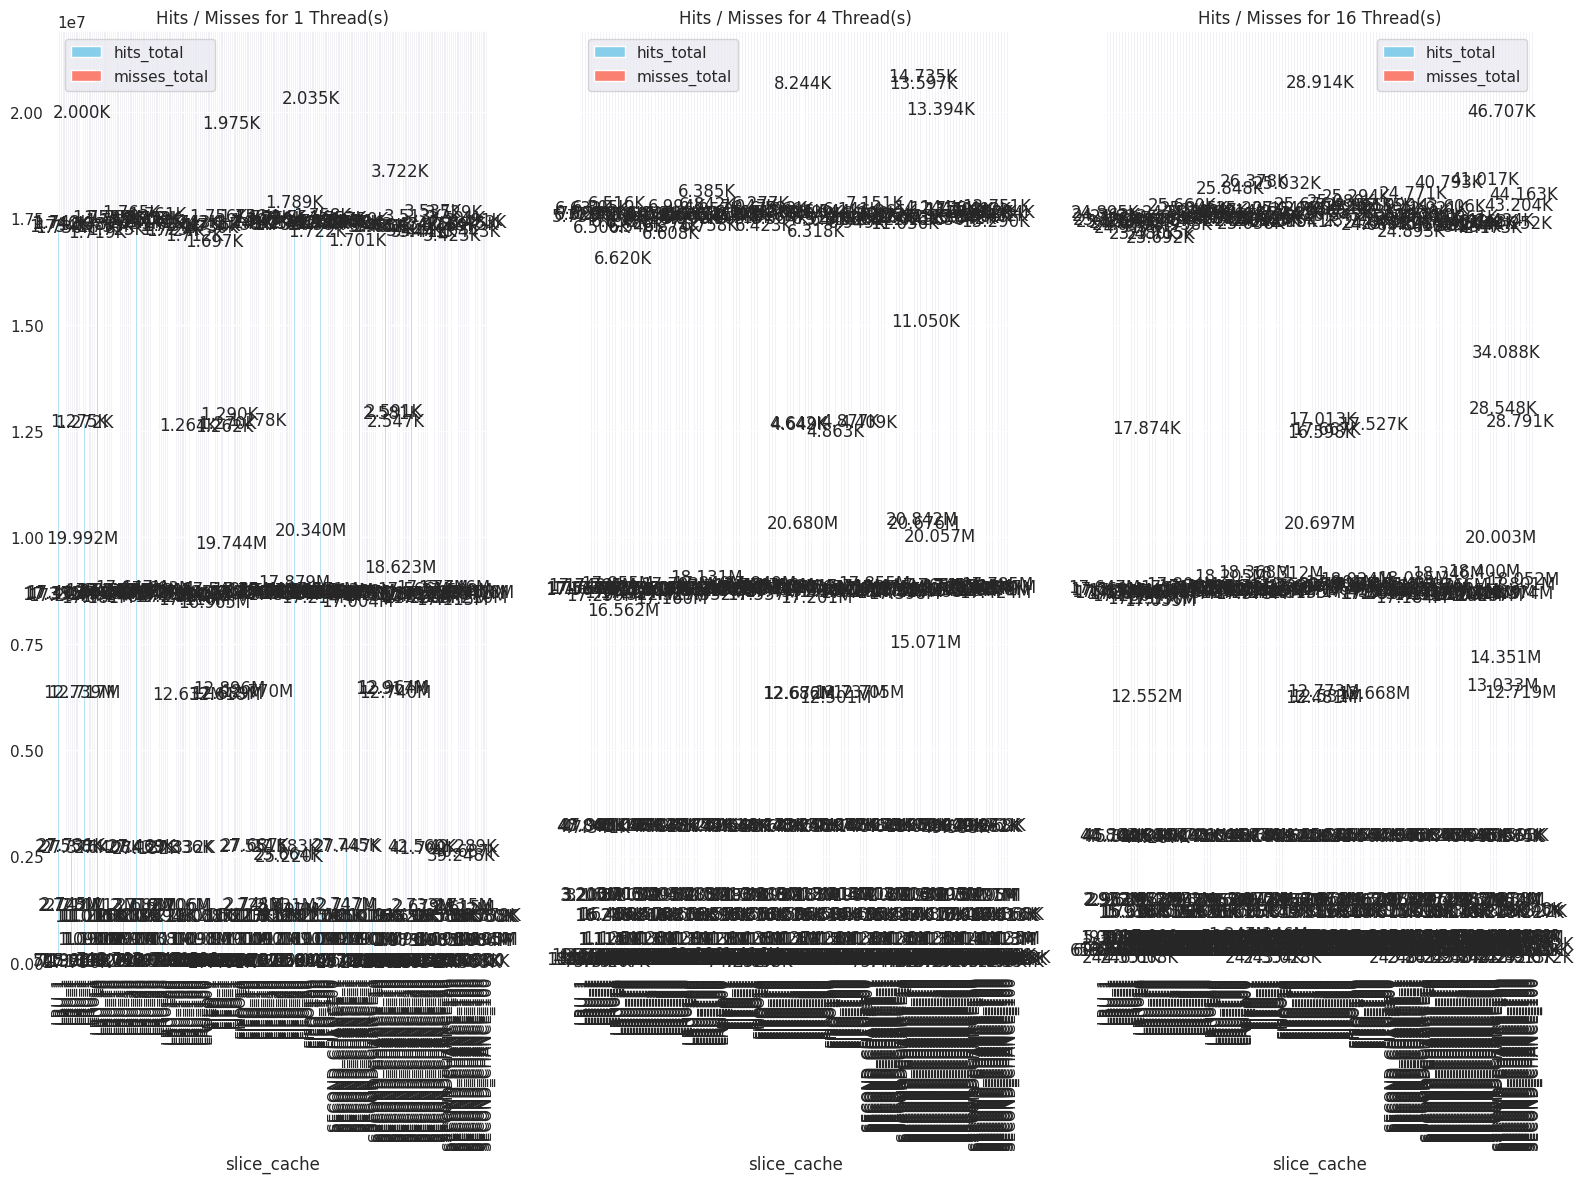

In [11]:
# Plotting the number of hits and misses per cache type
cache_stats_combined_df = load_cache_statistics()
interesting_param = "number_of_worker_threads"
x_param="slice_cache"
hue = "numberOfEntriesSliceCache"
y_params = ["hit_percentage", "hits_total", "misses_total"]
cache_stats_combined_df["hit_percentage"] = cache_stats_combined_df["hits_total"] / (cache_stats_combined_df["hits_total"] + 
                                                                                     cache_stats_combined_df["misses_total"])
#cache_stats_combined_df[x_param] = cache_stats_combined_df[x_param].apply(lambda x: '\n'.join(textwrap.wrap(x, width=5)))

# Create a subplot grid.
unique_params = cache_stats_combined_df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(16, 12), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = cache_stats_combined_df[cache_stats_combined_df[interesting_param] == param]
    plot_data = subset[["hits_total", "misses_total"]]
    plot_data.set_index(subset[x_param], inplace=True)
    ax = axes[0][idx]
    
    plot_data.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'salmon']) #, logy=True)
    ax.set_title(f"Hits / Misses for {param} Thread(s)")
    #ax.set_ylim(bottom=0.1)
    
    
    # Annotate the bars with hits and misses values
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        height_str = format_si_units(height)
        ax.text(x + width / 2, y + height / 2, f'{height_str}', horizontalalignment='center', verticalalignment='center')


plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()